In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


## Loading data and EDA

In [2]:
df = pd.read_csv("data/cleaned_hm.csv", index_col = 0).dropna()

In [3]:
df.head()

wid reflection_period  \
hmid                            
27676   206               24h   
27678    45               24h   
27697   498               24h   
27705  5732               24h   
27715  2272               24h   

                                             original_hm  \
hmid                                                       
27676  We had a serious talk with some friends of our...   
27678                            I meditated last night.   
27697  My grandmother start to walk from the bed afte...   
27705  I picked my daughter up from the airport and w...   
27715        when i received flowers from my best friend   

                                              cleaned_hm  modified  \
hmid                                                                 
27676  We had a serious talk with some friends of our...      True   
27678                            I meditated last night.      True   
27697  My grandmother start to walk from the bed afte...      True   
27705  I picked my daughter up from the airport and w...      True   
27715        when i received flowers from my best friend      True   

       num_sentence ground_truth_category predicted_category  
hmid                                                          
27676             2               bonding            bonding  
27678             1               leisure            leisure  
27697             1             affection          affection  
27705             1               bonding          affection  
27715             1               bonding            bonding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14125 entries, 27676 to 128764
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   wid                    14125 non-null  int64 
 1   reflection_period      14125 non-null  object
 2   original_hm            14125 non-null  object
 3   cleaned_hm             14125 non-null  object
 4   modified               14125 non-null  bool  
 5   num_sentence           14125 non-null  int64 
 6   ground_truth_category  14125 non-null  object
 7   predicted_category     14125 non-null  object
dtypes: bool(1), int64(2), object(5)
memory usage: 896.6+ KB


In [5]:
df.describe()

wid  num_sentence
count  14125.000000  14125.000000
mean    2647.277876      1.332248
std     3488.514951      1.236360
min        1.000000      1.000000
25%      384.000000      1.000000
50%     1043.000000      1.000000
75%     3249.000000      1.000000
max    13838.000000     44.000000

In [6]:
df = df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)
df.head()

wid reflection_period  \
hmid                            
27676   206               24h   
27678    45               24h   
27697   498               24h   
27705  5732               24h   
27715  2272               24h   

                                             original_hm  \
hmid                                                       
27676  We had a serious talk with some friends of our...   
27678                            I meditated last night.   
27697  My grandmother start to walk from the bed afte...   
27705  I picked my daughter up from the airport and w...   
27715        when i received flowers from my best friend   

                                                  moment  modified  \
hmid                                                                 
27676  We had a serious talk with some friends of our...      True   
27678                            I meditated last night.      True   
27697  My grandmother start to walk from the bed afte...      True   
27705  I picked my daughter up from the airport and w...      True   
27715        when i received flowers from my best friend      True   

       num_sentence     target predicted_category  
hmid                                               
27676             2    bonding            bonding  
27678             1    leisure            leisure  
27697             1  affection          affection  
27705             1    bonding          affection  
27715             1    bonding            bonding

# Word count

In [7]:
df['word_length'] = df['moment'].apply(lambda x: len(x.split()))
df.head()

wid reflection_period  \
hmid                            
27676   206               24h   
27678    45               24h   
27697   498               24h   
27705  5732               24h   
27715  2272               24h   

                                             original_hm  \
hmid                                                       
27676  We had a serious talk with some friends of our...   
27678                            I meditated last night.   
27697  My grandmother start to walk from the bed afte...   
27705  I picked my daughter up from the airport and w...   
27715        when i received flowers from my best friend   

                                                  moment  modified  \
hmid                                                                 
27676  We had a serious talk with some friends of our...      True   
27678                            I meditated last night.      True   
27697  My grandmother start to walk from the bed afte...      True   
27705  I picked my daughter up from the airport and w...      True   
27715        when i received flowers from my best friend      True   

       num_sentence     target predicted_category  word_length  
hmid                                                            
27676             2    bonding            bonding           25  
27678             1    leisure            leisure            4  
27697             1  affection          affection           12  
27705             1    bonding          affection           20  
27715             1    bonding            bonding            8

In [8]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [9]:
alt.Chart(df).mark_boxplot().encode(
    x='target',
    y='word_length'
).properties(
    width=600,
    height=300
)

alt.Chart(...)

Next, I split the data into train and test sets (keeping `moment` as a feature and `target` as our target):

In [10]:
train_df, test_df=train_test_split(df, test_size = 0.3, random_state=123)
X_train, y_train = train_df["moment"], train_df["target"]
X_test, y_test = test_df["moment"], test_df["target"]

<AxesSubplot:>

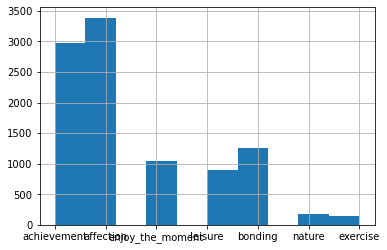

In [11]:
y_train.hist()

We note that most of the observations are categorized to be `achievement` or 'affection'. The distribution is unimodal with right-skewness and is centered around `affection` and `zchievement`. 

# Preprocessing

In [25]:
X_train.shape

(9887,)

In [28]:
preprocessor = make_pipeline(
    (CountVectorizer(stop_words = 'english'))
)

In [29]:
X_train_transformed = preprocessor.fit_transform(X_train)

Visualizing the transformed data:

In [32]:
transformed_df = pd.DataFrame(
    X_train_transformed.toarray(), columns = preprocessor.get_feature_names_out(), index = X_train)
transformed_df

00  000  0000  00am  04  \
moment                                                                        
I sorted and organized all my tax documents in ...   0    0     0     0   0   
Last week my dog had 8 puppies, adorable !           0    0     0     0   0   
I received my computer certification.                0    0     0     0   0   
An event that made me happy was seeing my girlf...   0    0     0     0   0   
My daughter had her 6 year old birthday.             0    0     0     0   0   
...                                                 ..  ...   ...   ...  ..   
My son started singing fun preschool songs on h...   0    0     0     0   0   
I was extremely happy receiving my vacation app...   0    0     0     0   0   
I successfully baked bread, which I haven't eve...   0    0     0     0   0   
When I graduated.                                    0    0     0     0   0   
I heard Bannon got a kick in the crotch and I k...   0    0     0     0   0   

                                                    05  07  10  100  1000  \
moment                                                                      
I sorted and organized all my tax documents in ...   0   0   0    0     0   
Last week my dog had 8 puppies, adorable !           0   0   0    0     0   
I received my computer certification.                0   0   0    0     0   
An event that made me happy was seeing my girlf...   0   0   0    0     0   
My daughter had her 6 year old birthday.             0   0   0    0     0   
...                                                 ..  ..  ..  ...   ...   
My son started singing fun preschool songs on h...   0   0   0    0     0   
I was extremely happy receiving my vacation app...   0   0   0    0     0   
I successfully baked bread, which I haven't eve...   0   0   0    0     0   
When I graduated.                                    0   0   0    0     0   
I heard Bannon got a kick in the crotch and I k...   0   0   0    0     0   

                                                    ...  yummy  zealand  \
moment                                              ...                   
I sorted and organized all my tax documents in ...  ...      0        0   
Last week my dog had 8 puppies, adorable !          ...      0        0   
I received my computer certification.               ...      0        0   
An event that made me happy was seeing my girlf...  ...      0        0   
My daughter had her 6 year old birthday.            ...      0        0   
...                                                 ...    ...      ...   
My son started singing fun preschool songs on h...  ...      0        0   
I was extremely happy receiving my vacation app...  ...      0        0   
I successfully baked bread, which I haven't eve...  ...      0        0   
When I graduated.                                   ...      0        0   
I heard Bannon got a kick in the crotch and I k...  ...      0        0   

                                                    zelda  zero  zoey  \
moment                                                                  
I sorted and organized all my tax documents in ...      0     0     0   
Last week my dog had 8 puppies, adorable !              0     0     0   
I received my computer certification.                   0     0     0   
An event that made me happy was seeing my girlf...      0     0     0   
My daughter had her 6 year old birthday.                0     0     0   
...                                                   ...   ...   ...   
My son started singing fun preschool songs on h...      0     0     0   
I was extremely happy receiving my vacation app...      0     0     0   
I successfully baked bread, which I haven't eve...      0     0     0   
When I graduated.                                       0     0     0   
I heard Bannon got a kick in the crotch and I k...      0     0     0   

                                                    zombies  zoo  zootopia  \
moment            

In [34]:
transformed_df.shape

(9887, 8060)

# Model building

I will try the four classification models: Decision Tree, RBF SVM, Multinomial Naive Bayes, and Logistics Regression. For each model, 5-fold cross-validation is carried out and the mean cross-validation scores, mean train scores, and mean fit and score times are reported. First, I define a function to easily report the cv scores...

In [35]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [36]:
results_dict = {}

models = {
    "Decision Tree": DecisionTreeClassifier(),
    "RBF SVM": SVC(),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000, multi_class='ovr'),
}

for model in models.keys():
    pipe = make_pipeline(preprocessor, models[model])
    results_dict[model] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True
    )

pd.DataFrame(results_dict)

Decision Tree            RBF SVM        Naive Bayes  \
fit_time     0.732 (+/- 0.051)  6.360 (+/- 0.038)  0.141 (+/- 0.003)   
score_time   0.030 (+/- 0.001)  0.868 (+/- 0.016)  0.031 (+/- 0.000)   
test_score   0.762 (+/- 0.010)  0.801 (+/- 0.013)  0.759 (+/- 0.007)   
train_score  0.997 (+/- 0.000)  0.930 (+/- 0.001)  0.861 (+/- 0.002)   

            Logistic Regression  
fit_time      0.844 (+/- 0.052)  
score_time    0.031 (+/- 0.002)  
test_score    0.824 (+/- 0.005)  
train_score   0.940 (+/- 0.001)

# Hyperparamater optimization

In [37]:
pipe_opt = make_pipeline(CountVectorizer(stop_words='english'),
                        LogisticRegression(max_iter=2000, multi_class='ovr')
                        )
params_grid = {"countvectorizer__max_features": [200, 500, 1000, 1800],
               "logisticregression__C": np.logspace(-3, 3, 7) 
              }
random_search = RandomizedSearchCV(
    pipe_opt,
    params_grid,
    n_jobs = -1,
    n_iter = 10,
    cv = 5,
    random_state = 123,
    return_train_score = True
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(stop_words='english')),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=2000,
                                                                 multi_class='ovr'))]),
                   n_jobs=-1,
                   param_distributions={'countvectorizer__max_features': [200,
                                                                          500,
                                                                          1000,
                                                                          1800],
                                        'logisticregression__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                   random_state=123, return_train_score=True)

In [38]:
random_search.best_params_

{'logisticregression__C': 1.0, 'countvectorizer__max_features': 1800}

In [39]:
random_search.best_score_

0.8211779242890817

In [40]:
results_final = pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "mean_train_score",
        "param_logisticregression__C",
        "param_countvectorizer__max_features",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T
results_final

rank_test_score                            1         2         3         4   \
mean_test_score                      0.821178  0.811771  0.790027  0.785071   
mean_train_score                     0.906544  0.957823  0.859664  0.866871   
param_logisticregression__C               1.0      10.0      10.0     100.0   
param_countvectorizer__max_features      1800      1800       500       500   
mean_fit_time                        0.985505  1.839419  1.675577  3.009307   

rank_test_score                            5         6         7         8   \
mean_test_score                      0.776677  0.763225  0.759986  0.682814   
mean_train_score                     0.942146  0.982098   0.78937  0.689314   
param_logisticregression__C            1000.0    1000.0     100.0      0.01   
param_countvectorizer__max_features      1000      1800       200       500   
mean_fit_time                        7.416594  6.711446  1.816644  0.488002   

rank_test_score                            9         10  
mean_test_score                      0.480024  0.473955  
mean_train_score                     0.484247   0.47833  
param_logisticregression__C             0.001     0.001  
param_countvectorizer__max_features      1800       500  
mean_fit_time                        0.449994  0.443982

# Results interpretation

Let's find out first few words which are positively (or negatively) associated with two classes: "affection" and "exercise". 

In [41]:
feature_names = random_search.best_estimator_["countvectorizer"].get_feature_names_out()
coeficients_affection = random_search.best_estimator_["logisticregression"].coef_[1].flatten()
df_affection = pd.DataFrame(coeficients_affection, index=feature_names, columns=['Affection coeff']).sort_values('Affection coeff', ascending=False)
df_affection[:5].append(df_affection[-5:])

Affection coeff
husband               5.533960
wife                  5.131838
son                   5.054281
brother               4.754134
daughter              4.699037
church               -1.946457
pray                 -1.991832
unforgettable        -2.089837
friends              -2.116366
friend               -2.763693

In [42]:
coeficients_exercise = random_search.best_estimator_["logisticregression"].coef_[4].flatten()
df_exercise = pd.DataFrame(coeficients_exercise, index=feature_names, columns=['Exercise coeff']).sort_values('Exercise coeff', ascending=False)
df_exercise[:5].append(df_exercise[-5:])

Exercise coeff
gym             4.489083
workout         4.206013
exercise        2.855086
yoga            2.734276
mile            2.479333
came           -1.022611
just           -1.134323
dog            -1.165117
got            -1.182366
daughter       -1.221494

# Test score and final evaluation

We then use the best model we found earlier (by hyperparameter optimization) and evaluate our model on the test data set. 

In [43]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.8178386031146767

The test score (0.8178) and cross validation scores (0.8212) are almost similar, therefore I expect the model to do as good in any unseen data. Let's further explore the test data set using probability scores. 